# DATASET description


The dataset 'data' contains records of the closing prices and trading volumes of 248 different stocks over several years. The following code implements and conducts backtests for various trading strategies, which can be applied to any specific stock within this dataset.

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('data.csv')
df
# print(df['ticker'].unique())

,ticker,date,last,volume
0,1332 JT,2013-01-04,169.0987,1464100
1,1332 JT,2013-01-07,166.3266,1783500
2,1332 JT,2013-01-08,166.3266,1759800
3,1332 JT,2013-01-09,165.4026,767800
4,1332 JT,2013-01-10,167.2507,1503100
...,...,...,...,...
451108,9984 JT,2021-03-15,10370.0000,12041200
451109,9984 JT,2021-03-16,10620.0000,11346000
451110,9984 JT,2021-03-17,10400.0000,9771000
451111,9984 JT,2021-03-18,10220.0000,13941600


# Getting necessary information about the selected stock from the dataset

The function 'get_stock' takes the ticker_id and returns a new data frame which contains the following information:

(i) All the dates/closing prices for the specified stock.

(ii) The 'Return' of the stock calculated as follows: Given a sequence of stock prices $\{x_1,x_2,\cdots,x_n\}$, the return of the stock price is the sequence $\{r_1,r_2,\cdots,r_n\}$, where $r_1=1$ and for any $k> 1$:
$$
r_k=\frac{x_{k}}{x_{k-1}}
$$
This sequence will help us in keeping track of our current balance: Given a intial balance of $S_{k_1}$, if we are in the market bewtween duration $k_1$ to $k_2$, our investment at time $k_2$ will be:
$$
S_{k_2} =\frac{x_{k_2}}{x_{k_1}}S_{k_1} = \frac{x_{k_2}}{x_{k_2-1}}  \frac{x_{k_2-1}}{x_{k_2-2}}\cdots\frac{x_{k_1-1}}{x_{k_1}} S_k=  r_{k_2} r_{k_2-1}\cdots r_{k_1} S_k
$$


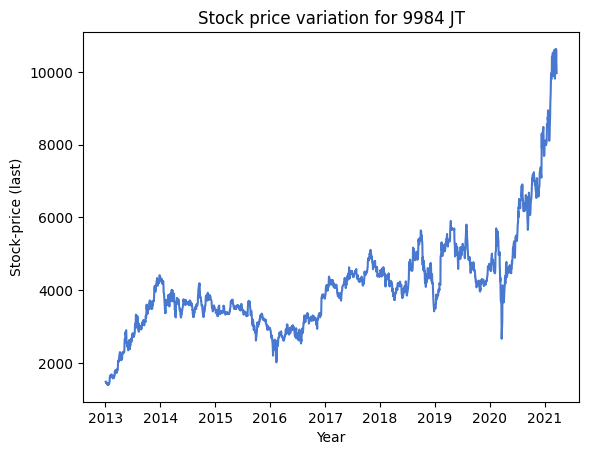

In [310]:
def get_stock(df, ticker_id):
  #  Get all entries corresponding to ticker_id
  price = df[df['ticker'] == ticker_id]
  price = price.drop(['ticker','volume'],1)
  price['date'] = pd.to_datetime(price['date'])

  # Define the return for the stock
  price['Return'] = price['last']/ price['last'].shift(1)
  price.Return.iat[0] = 1


  # Plot the stock variation
  price.set_index('date', inplace=True)
  plt.plot(price['last'])
  plt.xlabel('Year')
  plt.ylabel('Stock-price (last)')
  plt.title('Stock price variation for '+ticker_id)
  plt.show()
  return price

ticker_id = '9984 JT'
price = get_stock(df, ticker_id )


# **MACD Strategy**


The MAC-D strategy is implemented by constructing the MACD line, calculated by subtracting a longer-term Exponential Moving Average (EMA) of the closing prices from a shorter-term EMA.

The formula for MACD Line = Short-term EMA - Long-term EMA. Based on this, the Signal line is a 9-period EMA of the MACD line.

The strategy is decided as follows:
A buy signal occurs when the MACD line crosses above the Signal line.
A sell signal occurs when the MACD line crosses below the Signal line.

The function MACD takes the dataframe 'price' and adds a return column for MAC_D strategy, used later for backtesting.

In [311]:
def MACD(price):
  # Calculate the Exponential Moving Averages
  exp1 = price['last'].ewm(span = 12, adjust=False).mean()
  exp2 = price['last'].ewm(span = 26, adjust=False).mean()

  # Calculate the MACD and the signal line
  macd = exp1 - exp2
  signal = macd.ewm(span = 9, adjust=False).mean()

  # Generate return_MACD used later for backtesting (True in 'long' indicates that we are in the market
  # so return for MACD is just the correspoind entry in price['Return'] while False indicates we are
  # out of market so return = 1, i.e., we are holding).

  price['Long'] = macd > signal
  price['Return_MACD'] = np.where(price.Long.shift(1) == True, price.Return, 1)

  price = price.drop(['Long'],1)
  return price

# **RSI INDEX Strategy**


This stratgey uses the RSI index calculated using historical price data, typically over a specified period, to decide the strategy. This is calulated as follows:

(i) Daily price changes are calculated as the difference between consecutive closing prices. Gains are recorded when price changes are positive, and losses are recorded when price changes are negative.

(ii) Moving averages of gains and losses are computed over the RSI period to smooth out the data. RS is determined by dividing the average gain by the average loss. It measures the relative strength of price gains compared to losses.


There are two thresholds: Overbought and Oversold. Trading signals are generated based on RSI values crossing the overbought and oversold thresholds. The trading strategy is decided as:

- When RSI crosses above the overbought threshold (70), it means a sell signal.

- When RSI crosses below the oversold threshold (30), it means  a buy signal.


The RSI function takes the price data frame and calculates a return based on the RSI startegy in the same manner as MACD. The return is used later for backtesting.

In [312]:
def RSI(price):
  # Define parameters for the RSI strategy
  rsi_period = 14
  rsi_oversold = 30
  rsi_overbought = 70

  # Calculate daily price changes and the RSI
  price['price_change'] = price['last'].diff()
  price['gain'] = price['price_change'].apply(lambda x: x if x > 0 else 0)
  price['loss'] = price['price_change'].apply(lambda x: abs(x) if x < 0 else 0)

  # Calculate the average gain and average loss over the RSI period
  price['avg_gain'] = price['gain'].rolling(window=rsi_period).mean()
  price['avg_loss'] = price['loss'].rolling(window=rsi_period).mean()

  # Calculate the relative strength (RS) and the RSI
  price['rs'] = price['avg_gain'] / price['avg_loss']
  price['rsi'] = 100 - (100 / (1 + price['rs']))

  # Generate RSI-based Long (True or False)
  price['Long'] = (price['rsi'] >= rsi_oversold) & (price['rsi'] <= rsi_overbought)

  # Generate return for RSI return based on Long in the same manner as MACD
  price['Return_RSI'] = np.where(price.Long.shift(1) == True, price.Return, 1)


  price = price.drop(['price_change', 'gain','loss','avg_gain','avg_loss','rs','rsi','Long'],1)

  return price


**STOCHASTIC Strategy**
There are two main components to this stratgey:

%K Line: This is the main line that represents the current closing price relative to the range between the high and low prices over a specified lookback period (usually 14 periods).

%D Line: This is a moving average of the %K line.

Based on these components and pre-specified parameters, the trade startegy is decided according to the overbrough or oversold condition.


The stoch function takes the price data frame and calculates a return based on this startegy in the same manner as MACD and RSI. The return is used later for backtesting.



In [313]:
def stoch(price):
    k_period = 14
    d_period = 3
    stochastic_oversold = 20
    stochastic_overbought = 80

    # Calculate the Stochastic Oscillator values
    price['low'] = price['last'].rolling(window=k_period).min()
    price['high'] = price['last'].rolling(window=k_period).max()
    price['%k'] = 100 * ((price['last'] - price['low']) / (price['high'] - price['low']))
    price['%d'] = price['%k'].rolling(window=d_period).mean()

    # Generate Stochastic signals (True or False) to determin return for stoch
    Long = [False]

    for i in range(1,len(price['%d'])):
        if price['%k'][i] < price['%d'][i] and price['%k'][i] < stochastic_oversold and price['%d'][i] < stochastic_oversold:
            Long.append(True)
        elif price['%k'][i] > price['%d'][i] and price['%k'][i] > stochastic_overbought and price['%d'][i] > stochastic_overbought:
            Long.append(False)
        else:
            Long.append(Long[-1])




    price['Long'] = Long
    price['Return_stoch'] = np.where(price.Long.shift(1) == True, price.Return, 1)

    price = price.drop(['low', 'high','%k','%d','Long'],1)
    return price




# **BASELINE STARTEGY**

The baseline strategy will be used fo comparision purposes. This strategy essentially involves remaining in the market for all periods without active buying or selling decisions. Therefore, the return for this strategy is calculated in the same way as defined in the get_stock function, where the return is determined by dividing the current price by the previous price.

In [315]:
def Baseline(price):
  price['Return_Baseline']= price['Return']
  return price

# **BACKTESTING**

Finally, we conduct backtesting for all the strategies. This is achieved by sequentially invoking each strategy function, which generates returns for all time instances and incorporates them into the price DataFrame. These returns capture all the essential buy and sell signals information for each strategy and can be used to calculate the current balance at any time instant, assuming the starting balance is STARTING_BALANCE.


In [316]:
def backtest(price,STARTING_BALANCE):
  # bench_return will hold per cent change in balance for all the startgeies
  bench_return = {}

  # Call startegies
  for cur_strat in ['Baseline','MACD', 'RSI','stoch']:
    if cur_strat =='Baseline':
      price = Baseline(price)
    elif cur_strat =='MACD':
      price = MACD(price)
    elif cur_strat =='RSI':
      price = RSI(price)
    elif cur_strat =='stoch':
      price = stoch(price)

    # Calculate the balance for all time
    price['balance_'+ cur_strat] = STARTING_BALANCE * price['Return_'+cur_strat].cumprod()

    #  Calculate the per cent change in balance
    bench_return[cur_strat] = round(((price['balance_'+cur_strat][-1]/price['balance_'+cur_strat][0]) - 1) * 100, 2)

  return bench_return, price

bench_return,price = backtest(price,10000)

# **VISUALIZATION AND OBSERVATIONS:**

For the sake of simplicity, we focus solely on plotting the balance versus time and the percentage change in investment in this context. It's important to note that these results can serve as a basis for calculating various other performance metrics and criteria as well.

Some general observations are:

(i) In cases where stocks demonstrate a positive net gain (final_price - initial_price > 0), the baseline strategy typically exhibits strong performance.

(ii) Conversely, when stocks show a negative net gain (final_price - initial_price < 0), strategies other than the baseline may result in smaller losses.

(iii) Determining the best strategy is not obvious since performance can vary significantly depending on the stock.

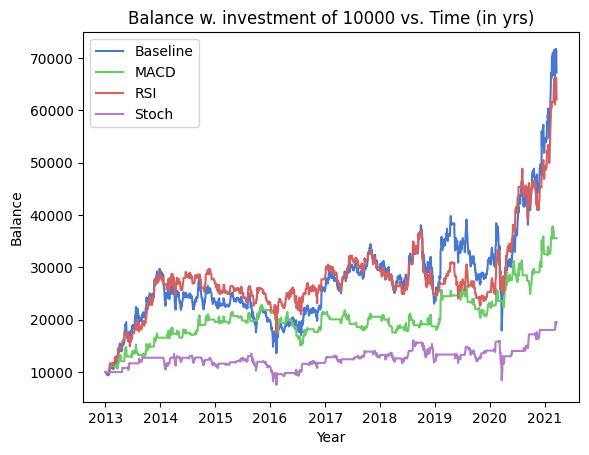

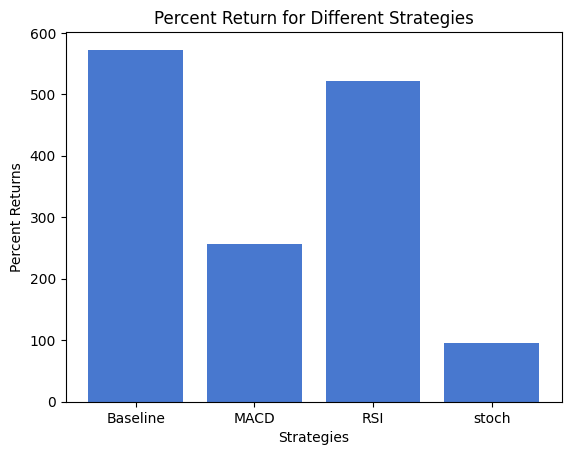

In [317]:
#  Data Visualization

# Balance vs time

plt.plot(price['balance_Baseline'], label='Baseline')
plt.plot(price['balance_MACD'], label='MACD')
plt.plot(price['balance_RSI'], label='RSI')
plt.plot(price['balance_stoch'], label='Stoch')

plt.xlabel('Year')
plt.ylabel('Balance')
plt.title('Balance w. investment of 10000 vs. Time (in yrs)')
plt.legend()


plt.show()

# Per cent return

keys = list(bench_return.keys())
values = list(bench_return.values())

plt.bar(keys, values)
plt.xlabel('Strategies')
plt.ylabel('Percent Returns')
plt.title('Percent Return for Different Strategies')

plt.show()